In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Print head of cleaned dataset
DatabaseDF = pd.read_csv("../CleanedDataset.csv")
DatabaseDF.head()

,Unnamed: 0,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs",...,Fluid Type from DI,SPACING_CAPPED,12 month Cum Prod,Completion Type,Sleeves,P&P,Frac Ports,Repeater Ports,CT,Year Drilled
0,0,Operator 1,Well 1,MBH,5114.0,30.0,141,99,10,0.0,...,NaN,660.0,33.55,NaN,NaN,NaN,NaN,NaN,NaN,2006.0
1,1,Operator 2,Well 2,MBH,5181.0,NaN,142,99,16,418000.0,...,NaN,660.0,27.62,NaN,NaN,NaN,NaN,NaN,NaN,2005.0
2,2,Operator 2,Well 3,MBH,4780.0,15.0,142,99,24,568407.0,...,NaN,660.0,11.19,OH,NaN,NaN,NaN,NaN,NaN,2006.0
3,3,Operator 1,Well 4,MBH,10654.0,1.0,142,99,1,845000.0,...,NaN,660.0,27.85,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
4,4,Operator 2,Well 5,MBH,5209.0,1.0,142,99,35,297366.0,...,NaN,660.0,50.88,OH,NaN,NaN,NaN,NaN,NaN,2006.0


# Model Definition: Pareto Chart

A Pareto Chart is a combination of a bar graph and line graph used in Economics and Business that shows the influence that various (independent) categorical variables have on a continuous (dependent) variable in the dataset. The bars are ordered such that the most frequent or prominent independent variable is on the left and the least significant variable is on the right. The line graph represent the cumulative percentages of the dependent variable and how each independent variable contributes to that percentage.

This model is more of a tool that helps analyze different features and which of them should be prioritized; it is not used for estimating a value. Pareto Charts are good if you want to narrow down the features to find the most frequent/prominent  ones, so that you can focus on the ones that are the most impactful for the final product or for a certain variable.

A Pareto Chart can be applied to oil because it can be help us narrow down certain variables by seeing which ones affect cumulative oil production the most. From there, we can decide how to distribute resources in order to maximize production. 

## More information about the ANOVA correlation and interpretation of results towards the end of the notebook.

# Plotting completion and formation types and their counts simply to visualize the data.

In [24]:

DatabaseDF['Completion Type'].value_counts(dropna = False)

P & P                            4845
Sleeves                          4250
OH                                687
NaN                               658
Sleeves and P & P                 360
Cemented Liner                     18
CT                                 14
Frac Ports and P & P                7
Frac Ports                          7
Frac Ports and Repeater Ports       3
Repeater Ports and P & P            2
Perforated Liner                    2
Screen                              2
P & P and CT                        1
Name: Completion Type, dtype: int64

In [174]:
#Function to plot pareto chart
def pareto_plot(x , counts, xlabel = "x-axis", ylabel = 'Counts', show_pct_y=False, pct_format='{0:.0%}'):

    weights = counts/counts.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots(figsize = (15,10))
    ax1.bar(x, counts)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    plt.xticks(rotation = 25)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    plt.ylim(bottom = 0)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if xlabel is not "x-axis":
        plt.title(xlabel + " Pareto Chart")
    
    plt.tight_layout()
    plt.show()

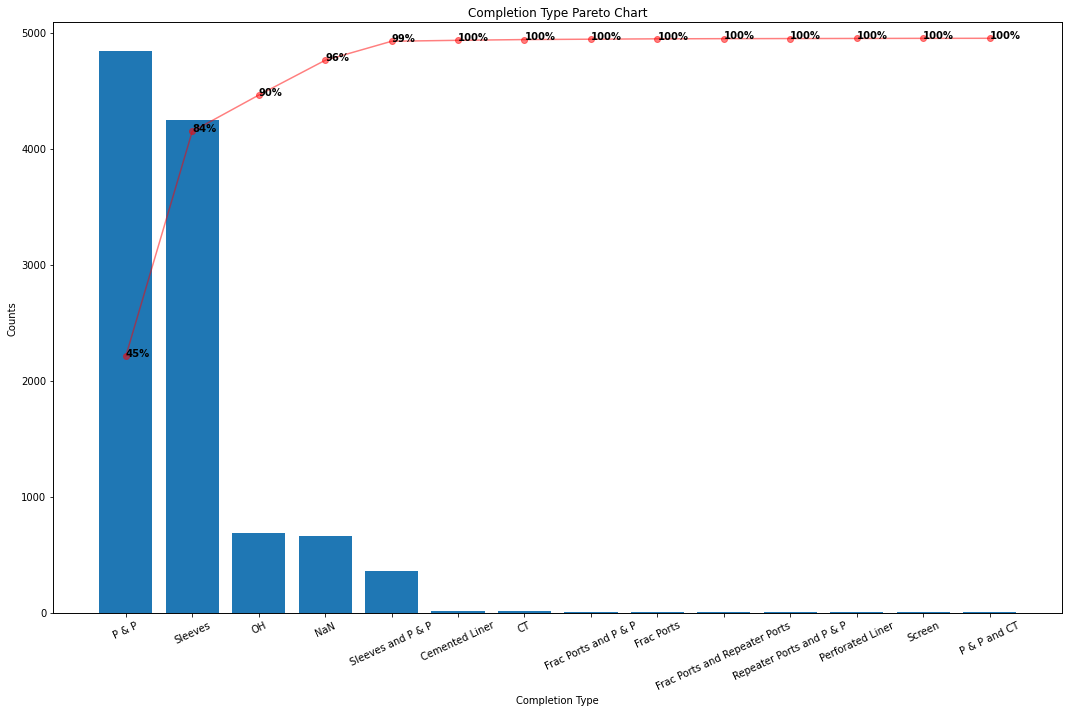

In [27]:
#Plot pareto chart for each completion type and its counts
valuesSeries = DatabaseDF['Completion Type'].fillna('NaN').value_counts()

pareto_plot(x = valuesSeries.index, counts = valuesSeries.values, xlabel = 'Completion Type')

The P&P and Sleeves completion types seem to be the most frequent in the dataset, where P&P accounts for 45% of the completions and Sleeves accounts for 39% of the completions.

In [28]:
DatabaseDF['Formation'].value_counts(dropna = False)

MBH        7065
TFH        3576
TF2          82
MBH/TFH      58
TF1          33
TF3          16
NaN           8
UTFH          6
TFSH          4
MTFH          4
TF2.5         2
TF4           2
Name: Formation, dtype: int64

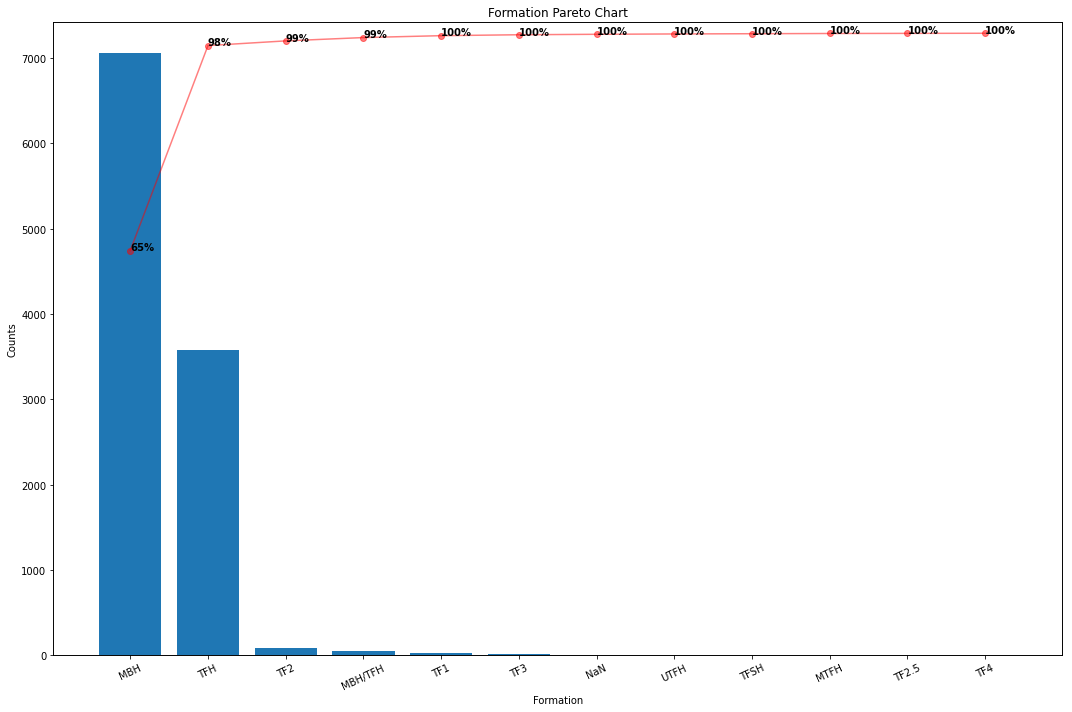

In [29]:
#Plot pareto chart for each completion type and its counts
valuesSeries = DatabaseDF['Formation'].fillna('NaN').value_counts()

pareto_plot(x = valuesSeries.index, counts = valuesSeries.values, xlabel = 'Formation')

The MBH and TFH formation types seem to be the most frequent in the dataset, where MBH accounts for 65% of the formations and TFH accounts for 33% of the formations.

# Plotting Pareto Chart for both the completion types and formation types and how the types affect cumulative oil production.

In [88]:

formation_types = ['MBH', 'TFH', 'TF2', 'MBH/TFH', 'TF1', 'TF2', 'UTFH', 'TFSH', 'MTFH', 'TF4']

#Function to calculate value of cumulative oil production associated with each type of formation
def oil_prod(formation_string, feature1, feature2):
    count = 0
    oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(DatabaseDF.index) 
    for item in range(num_rows - 1):
        if DatabaseDF.at[item, feature1] == formation_string:
            count += 1
            oil_production += DatabaseDF.at[item,feature2]
    return oil_production

#Append oil production values to list 
form_oilprod = []
for i in formation_types:
    form_oilprod.append(oil_prod(i, 'Formation', '12 month Cum Prod'))

#Create dataframe for Pareto Chart with formation types
df = pd.DataFrame({
    'Formation Type': formation_types,
    'Oil Production': form_oilprod
})

In [89]:
FormationProductionDict = {}

for formation in DatabaseDF['Formation'].fillna('NaN').unique():
    validWells = DatabaseDF[DatabaseDF['Formation'].fillna('NaN') == formation]
    FormationProductionDict[formation] = validWells['12 month Cum Prod'].sum()

FormationProductionDict = sorted(FormationProductionDict.items(), key = lambda x: x[1], reverse = True)

Formations, Production = zip(*FormationProductionDict)

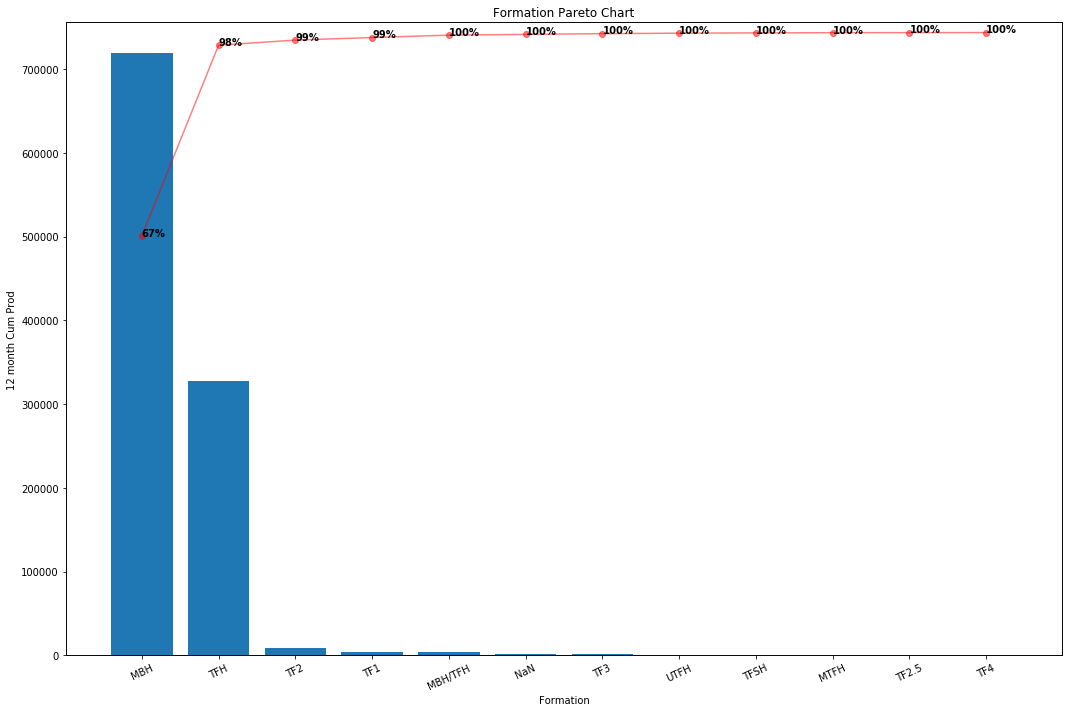

In [90]:
pareto_plot(x = pd.Series(Formations), counts = pd.Series(Production), xlabel = 'Formation', ylabel = '12 month Cum Prod')

The MBH and TFH formation types seem to be the most impactful on oil production in the dataset, where the MBH formation is associated with 67% of the cumulative production and TFH is associated with 31% of the cumulative production.

In [85]:
#Append oil production values to list 
completion_types = ['zero', 'OH', 'Sleeves', 'P & P', 'Sleeves and P & P', 'Screen',
       'Cemented Liner', 'Perforated Liner', 'Frac Ports',
       'Frac Ports and P & P', 'Frac Ports and Repeater Ports', 'CT',
       'P & P and CT', 'Repeater Ports and P & P']
compl_oilprod = []
for i in completion_types:
    compl_oilprod.append(oil_prod(i, 'Completion Type', '12 month Cum Prod'))

#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Completion Type': completion_types,
    'Oil Production': compl_oilprod
})

In [86]:
CompletionProductionDict = {}

for completion in DatabaseDF['Completion Type'].fillna('NaN').unique():
    validWells = DatabaseDF[DatabaseDF['Completion Type'].fillna('NaN') == completion]
    CompletionProductionDict[completion] = validWells['12 month Cum Prod'].sum()

CompletionProductionDict = sorted(CompletionProductionDict.items(), key = lambda x: x[1], reverse = True)

Completions, Production = zip(*CompletionProductionDict)

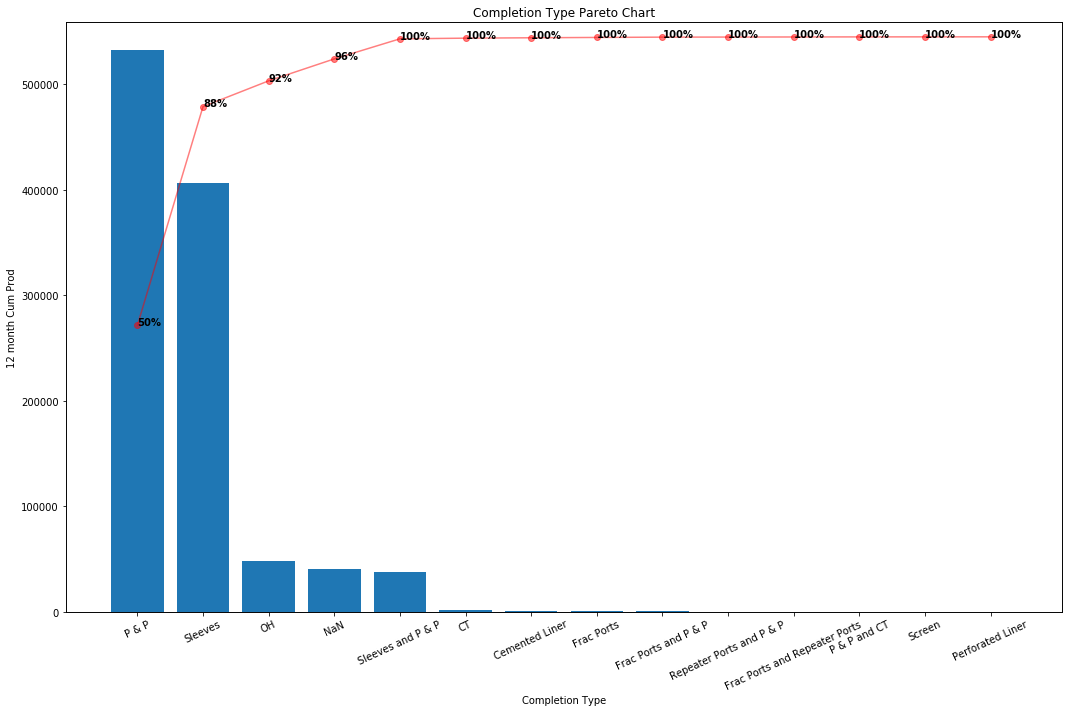

In [87]:
#Plot pareto chart for each completion type and how they are related to total oil production
pareto_plot(x = pd.Series(Completions), counts = pd.Series(Production), xlabel = 'Completion Type', ylabel = '12 month Cum Prod')

The P&P and Sleeves completion types seem to be the most impactful on the oil production in the dataset, where P&P is associated with for 50% of the cumulative production and Sleeves is associated with 38% of the cumulative production.

# Plotting Fluid Type against Cumulative Oil Production.

In [75]:
#Append oil production values to list 
fluid_types = ['LINEAR GEL (HC)', 'CROSSLINKED (HC)', 'SLICKWATER (HC)',
       'SW-XL HYBRID', 'CROSSLINKED', 'UNKNOWN', 'SW-GEL HYBRID',
       'LINEAR GEL']
fluid_oilprod = []
for i in fluid_types:
    fluid_oilprod.append(oil_prod(i, 'Fluid Type from DI', '12 month Cum Prod'))

#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Fluid Type': fluid_types,
    'Oil Production': fluid_oilprod
})

In [117]:
#Rescaling chart to reflect percentages
FluidProductionDict = {}

for fluid in DatabaseDF['Fluid Type from DI'].dropna().unique():
    validWells = DatabaseDF[DatabaseDF['Fluid Type from DI'].fillna('NaN') == fluid]
    FluidProductionDict[fluid] = validWells['12 month Cum Prod'].sum()

FluidProductionDict = sorted(FluidProductionDict.items(), key = lambda x: x[1], reverse = True)

Fluids, Production = zip(*FluidProductionDict)

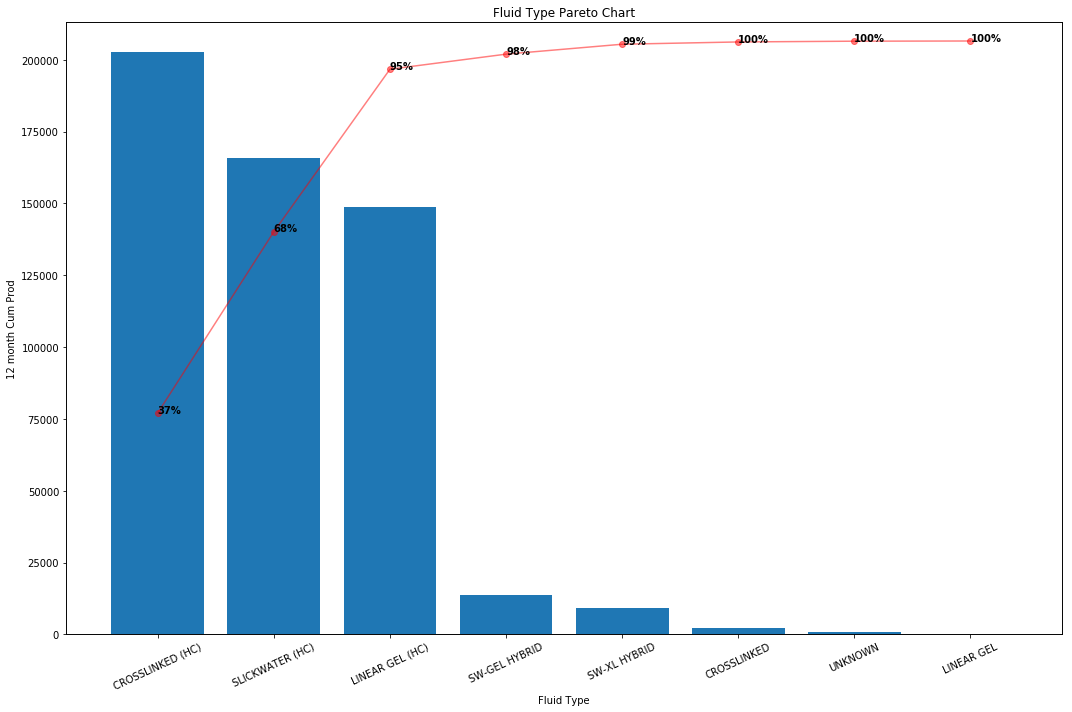

In [118]:
#Plot pareto chart for each completion type and how they are related to total oil production
pareto_plot(x = pd.Series(Fluids), counts = pd.Series(Production), xlabel = 'Fluid Type', ylabel = '12 month Cum Prod')

# Plotting number of stages versus oil production

In [153]:
#Unique number of stages
DatabaseDF['Stages'].unique()
stage_numbers= [30., 15.,  1., 18., 10.,  2.,  8.,  4., 11., 20., 39., 29.,
       27., 22., 21., 23., 35., 24., 17., 26., 40., 12., 13., 47., 28.,
       50.,  9.,  6., 36.,  5.,  7., 14., 16., 19., 38., 31., 37., 25.,
       32., 34., 33., 51., 45., 54., 43., 46.,  3., 41., 49., 44., 42.,
       48., 80., 56., 64., 69., 62., 59., 55., 94., 60., 57., 53., 65.,
       61., 52., 78., 68., 58., 82., 81., 79., 88., 84., 83., 63., 86.,
       90., 72., 89., 71., 70.]
stage_numbers.sort()

In [76]:
#Calculate oil production
stage_oilprod = []
for i in stage_numbers: 
    stage_oilprod.append(oil_prod(i, 'Stages', '12 month Cum Prod')) 

## Head-Tail Break Clustering Algorithm

In [77]:
#Function for head-tails break algorithm, to cluster and group data
def htb(data):
    """
    Applies the head/tail breaks algorithm to an array of data.
    Params
    ------
    data : list
        Array of data to apply ht-breaks
    Returns
    -------
    results : list 
        List of data representing break points
    """
    # test input
    assert data, "Input must not be empty."
    assert all(isinstance(datum, int) or isinstance(datum, float) for datum in data), "All input values must be numeric."

    results = []  # array of break points

    def htb_inner(data):
        """
        Inner ht breaks function for recursively computing the break points.
        """
        # Add mean to results
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        results.append(data_mean)

        # Recursive call to get next break point
        head = [datum for datum in data if datum > data_mean]
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)

    htb_inner(data)

    return results

In [78]:
#Find head-tail break value for stage numbers
htb(stage_numbers)

[42.792682926829265]

In [103]:
#Find oil production for each stage interval
interval1 = 0
interval2 = 0

for i in stage_numbers:
    if i <= 42.792682926829265:
        interval1 += (oil_prod(i, 'Stages', '12 month Cum Prod'))
    else:
        interval2 += (oil_prod(i, 'Stages', '12 month Cum Prod'))

In [108]:
#Create lists for pareto chart dataframe
stages_oilprod = []
stages_oilprod.append(interval1)
stages_oilprod.append(interval2)
stages_number = ['Stages 0 - 42', 'Stages 43 - 94']

# Pareto Plot Function

In [183]:
#Function to plot pareto chart

def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots()
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

In [184]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Stages': stages_number,
    'Oil Production': stages_oilprod
})

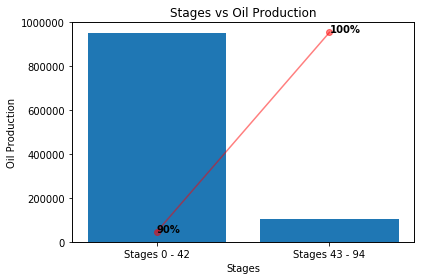

In [83]:
#Plot pareto chart for each completion type and its counts
pareto_plot(df, x='Stages', y='Oil Production', title='Stages vs Oil Production')

# Plotting Year Drilled versus Oil Production.

In [114]:
#Find Years Drilled and oil production for each year
DatabaseDF['Year Drilled'].dropna().unique()
years = [2006., 2005., 2007., 2008., 2004., 2009., 2011., 2012., 2010., 2013., 2014., 2016., 2015., 2017.]
years.sort()
year_oilprod = []
for i in years:
    year_oilprod.append(oil_prod(i, 'Year Drilled', '12 month Cum Prod'))

In [116]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Year Drilled': years,
    'Oil Production': year_oilprod
})

In [127]:
#Rescaling chart to reflect percentages
YearProductionDict = {}

for year in DatabaseDF['Year Drilled'].dropna().unique():
    validWells = DatabaseDF[DatabaseDF['Year Drilled'].fillna('NaN') == year]
    YearProductionDict[year] = validWells['12 month Cum Prod'].sum()

YearProductionDict = sorted(YearProductionDict.items(), key = lambda x: x[1], reverse = True)

Years, Production = zip(*YearProductionDict)

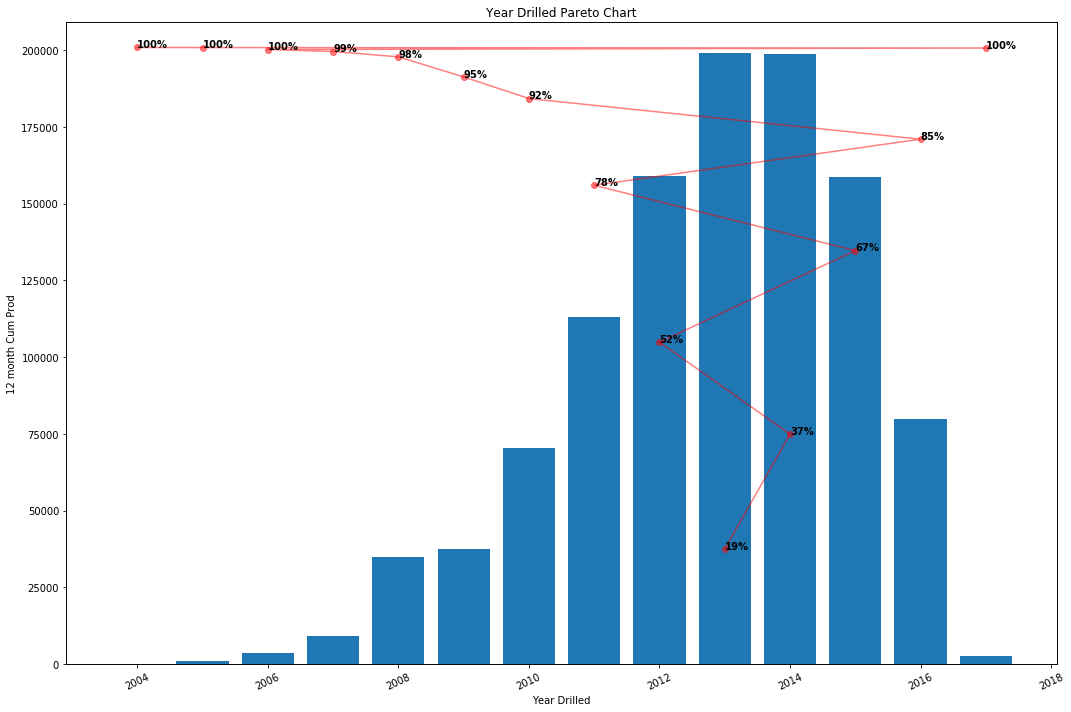

In [128]:
#Plot pareto chart for each completion type and how they are related to total oil production
pareto_plot(x = pd.Series(Years), counts = pd.Series(Production), xlabel = 'Year Drilled', ylabel = '12 month Cum Prod')

# Plotting Total Proppant versus Oil Production

In [155]:
#Divide Total Proppant values into 4 different intervals
(DatabaseDF['Total Prop, lbs'].max() - DatabaseDF['Total Prop, lbs'].min()) / 4

7186141.75

In [156]:
#Create bins
bins = (0, 7186141.75, 14372283.5, 21558425.25, 28744567.0)
groupnames = ['0 - 7.2M lbs', '7.2M - 14.4M lbs', '14.4M - 21.6M', '21.6M - 28.8M']
DatabaseDF['Proppant Bins'] = pd.cut(DatabaseDF['Total Prop, lbs'], bins = bins, labels = groupnames)

In [157]:
#Distinction between 4 intervals
DatabaseDF['Proppant Bins'].dropna().unique()
prop_intervals = ['0 - 7.2M lbs', '7.2M - 14.4M lbs', '14.4M - 21.6M', '21.6M - 28.8M']

In [158]:
#Calculate oil production
prop_oilprod = []
for i in prop_intervals:
    prop_oilprod.append(oil_prod(i, 'Proppant Bins', '12 month Cum Prod'))

In [164]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Total Proppant Intervals': prop_intervals,
    'Oil Production': prop_oilprod
})

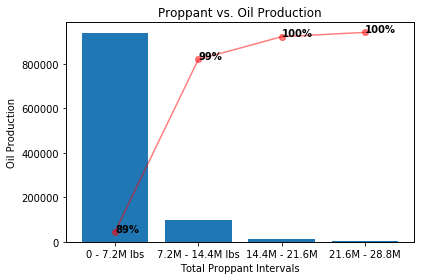

In [165]:
#Plot pareto chart for each formation type and how they are related to total oil production
pareto_plot(df, x='Total Proppant Intervals', y='Oil Production', title= 'Proppant vs. Oil Production')

In [166]:
#Plot pareto chart for each completion type and how they are related to total oil production
#pareto_plot(x = pd.Series(Proppant), counts = pd.Series(Production), xlabel = 'Total Proppant', ylabel = '12 month Cum Prod')

# Plotting amount of Fluid versus Oil Production

In [167]:
#Divide Total Proppant values into 4 different intervals
(DatabaseDF['Fluid, bbls'].max() - DatabaseDF['Fluid, bbls'].min()) / 4

149640.5

In [168]:
#Create bins
bins = (0, 149640.5, 299281.0, 448921.5 , 598562.0)
groupnames = ['0 - 150K bbls', '150K bbls - 300K bbls', '300K bbls - 450K bbls', '450K bbls- 600K bbls']
DatabaseDF['Fluid Bins'] = pd.cut(DatabaseDF['Fluid, bbls'], bins = bins, labels = groupnames)

In [169]:
#Distinction between 4 intervals
DatabaseDF['Fluid Bins'].dropna().unique()
fluid_intervals = ['0 - 150K bbls', '150K bbls - 300K bbls', '300K bbls - 450K bbls', '450K bbls- 600K bbls']

In [170]:
fluid_oilprod = []
for i in fluid_intervals:
    fluid_oilprod.append(oil_prod(i, 'Fluid Bins', '12 month Cum Prod'))

In [171]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Fluid Intervals': fluid_intervals,
    'Oil Production': fluid_oilprod
})

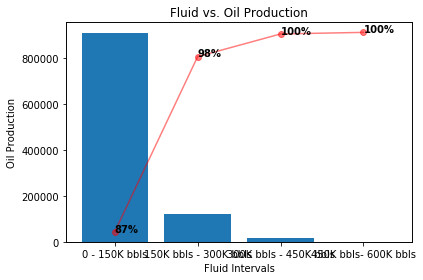

In [33]:
#Plot pareto chart for each formation type and how they are related to total oil production
pareto_plot(df, x='Fluid Intervals', y='Oil Production', title= 'Fluid vs. Oil Production')

# Plotting Spacing Capped versus Oil Production

In [178]:
#Calculate interval length for spacing
(DatabaseDF['SPACING_CAPPED'].max() - DatabaseDF['SPACING_CAPPED'].min()) / 4

160.48129625

In [65]:
#Create bins
bins = (18.074815, 178.55611125, 339.0374, 499.51870375, 660.0)
groupnames = ['18 - 178.6', '178.6 - 339.0', '339.0 - 500.0', '500.0 - 660.0']
DatabaseDF['Spacing Bins'] = pd.cut(DatabaseDF['SPACING_CAPPED'], bins = bins, labels = groupnames)

In [66]:
#Distinction between 4 intervals
DatabaseDF['Spacing Bins'].dropna().unique()
spacing_intervals = ['18 - 178.6', '178.6 - 339.0', '339.0 - 500.0', '500.0 - 660.0']

In [67]:
#Calculate oil production
spacing_oilprod = []
for i in spacing_intervals:
    spacing_oilprod.append(oil_prod(i, 'Spacing Bins', '12 month Cum Prod'))

In [68]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Spacing Intervals': spacing_intervals,
    'Oil Production': spacing_oilprod
})

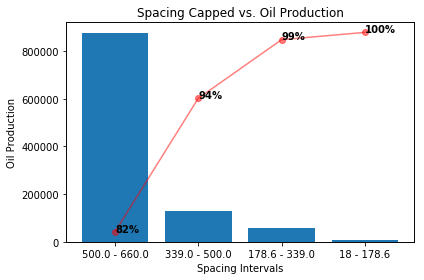

In [69]:
#Plot pareto chart for each formation type and how they are related to total oil production
pareto_plot(df, x='Spacing Intervals', y='Oil Production', title= 'Spacing Capped vs. Oil Production')

# Comparing all features versus oil production

In [179]:
#Create lists to compare all features and the oil production of each feature's unique component 
total_oilprod = []
label = []
total_oilprod.append(max(form_oilprod))
label.append('Formation')
total_oilprod.append(max(compl_oilprod))
label.append('Completion Type')
total_oilprod.append(max(fluid_oilprod))
label.append('Fluid Type')
total_oilprod.append(max(stages_oilprod))
label.append('Stage')
total_oilprod.append(max(year_oilprod))
label.append('Year')
total_oilprod.append(max(spacing_oilprod))
label.append('Spacing Capped')
total_oilprod.append(max(fluid_oilprod))
label.append('Fluid')
total_oilprod.append(max(prop_oilprod))
label.append('Total Proppant')

In [186]:
#Create dataframe for Pareto Chart with completion types
df = pd.DataFrame({
    'Feature': label,
    'Oil Production': total_oilprod
})

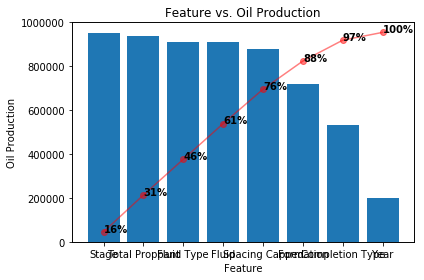

In [187]:
#Plot pareto chart for each formation type and how they are related to total oil production
pareto_plot(df, x='Feature', y='Oil Production', title= 'Feature vs. Oil Production')

In [84]:
'''This is a really good model. Of course, once we have research components figured out, I think using that of what we have learned onto this model will be beneficial.'''

'This is a really good model. Of course, once we have research components figured out, I think using that of what we have learned onto this model will be beneficial.'